# 期末報告
#### 組員: 廖品瑜、胡筆勝

## 1.Dataset簡介
#### 這個資料集收集了從2007年起澳洲各地天氣站的氣象資料，包含今天是否降雨、降雨量、蒸發量、日照、不同時段的風速與風向、不同時段的溫度以及明天是否降雨...等等不同資料。

#### 網址:https://www.kaggle.com/jsphyg/weather-dataset-rattle-package

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd
# machine learning
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
# visualization
import seaborn as sns
import matplotlib.pyplot as plt

## 2.問題定義
#### 根據今天的各種氣象資料，訓練一個模型預測澳洲明天會不會下雨。

In [2]:
#read in
pd_data = pd.read_csv('../input/weatherAUS.csv')
pd_data.shape

(142193, 24)

## 3.資料前處理
#### 3.1 首先將有缺失的列刪除，避免資料不足難以預測。



In [3]:
#drop NAN
pd_data=pd_data.dropna(how='any')
print(pd_data.shape)

(56420, 24)



#### 3.2 我們認為日期、地點都不是影響明日是否會下雨的因素，因此將'Date','Location'刪除。
#### 'WindGustDir', 'WindDir9am', 'WindDir3pm'為風向，分由於是以文字表示，難轉換成數字，因此在此先不考慮。
#### 'RISK_MM'是氣象局給出的明天雨量估計，基本上就是我們要的結果，若將此行加入會overfitting，故刪除。


In [4]:
#drop something column
drop_columns_list = ['WindGustDir', 'WindDir9am', 'WindDir3pm','Date','Location','RISK_MM']
pd_data = pd_data.drop(drop_columns_list, axis=1)
print(pd_data.shape)
pd_data.head()

(56420, 18)


,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
5939,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No
5940,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No
5942,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No
5943,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No
5944,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,No,No


In [5]:
#change yes/no to 1/0
pd_data['RainToday'].replace({'No':0,'Yes':1},inplace=True)
pd_data['RainTomorrow'].replace({'No':0,'Yes':1},inplace=True)
pd_data.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
5939,17.9,35.2,0.0,12.0,12.3,48.0,6.0,20.0,20.0,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,0,0
5940,18.4,28.9,0.0,14.8,13.0,37.0,19.0,19.0,30.0,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,0,0
5942,19.4,37.6,0.0,10.8,10.6,46.0,30.0,15.0,42.0,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,0,0
5943,21.9,38.4,0.0,11.4,12.2,31.0,6.0,6.0,37.0,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,0,0
5944,24.2,41.0,0.0,11.2,8.4,35.0,17.0,13.0,19.0,15.0,1010.7,1007.4,1.0,6.0,33.6,37.6,0,0


#### 3.3 RainToday原本由Yes/No組成，將其改為Yes=1,No=0
####    將資料分成訓練Train與測試Test部分，Train占了55000筆，Test有1420筆，並把要得出的結果切出來。

In [6]:
#Task: Split the data into train and test
train_y = pd_data['RainTomorrow'].head(55000)
test_y= pd_data['RainTomorrow'].tail(1420)
train_x = pd_data.head(55000).drop(['RainTomorrow'], axis=1)
test_x= pd_data.tail(1420).drop(['RainTomorrow'], axis=1)
print(train_y.head())
print(train_x.head())

5939    0
5940    0
5942    0
5943    0
5944    0
Name: RainTomorrow, dtype: int64
      MinTemp  MaxTemp  Rainfall    ...      Temp9am  Temp3pm  RainToday
5939     17.9     35.2       0.0    ...         26.6     33.4          0
5940     18.4     28.9       0.0    ...         20.3     27.0          0
5942     19.4     37.6       0.0    ...         28.7     34.9          0
5943     21.9     38.4       0.0    ...         29.1     35.6          0
5944     24.2     41.0       0.0    ...         33.6     37.6          0

[5 rows x 17 columns]


## 4.模型

### 4.1 Decision tree

In [7]:
import graphviz 
dtree=tree.DecisionTreeClassifier(max_depth=3)
dtree=dtree.fit(train_x,train_y)
dot_data = tree.export_graphviz(dtree, 
                filled=True, 
                feature_names=list(train_x),
                class_names=['No rain','rain'],
                special_characters=True)
graph = graphviz.Source(dot_data)  


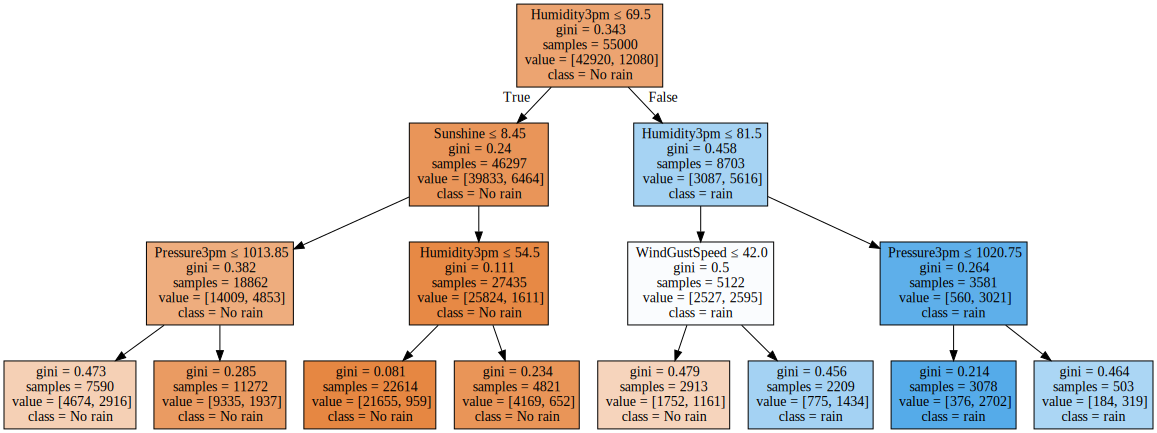

In [8]:
graph

In [9]:
#不同資料與結果的關聯性
dtree.feature_importances_


array([0.        , 0.        , 0.        , 0.        , 0.15214802,
       0.02723808, 0.        , 0.        , 0.        , 0.74114532,
       0.        , 0.07946858, 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [10]:
#把訓練好的模型套用到測試數據
predict_y = dtree.predict(test_x)
predict_y

array([0, 0, 0, ..., 0, 0, 0])

In [11]:
#計算訓練數據與測試數據的正確率
from sklearn.metrics import accuracy_score
acc_log = dtree.score(train_x, train_y)
print('training accuracy: %.5f' % acc_log)
x=accuracy_score(test_y, predict_y)
print('test accuracy: %.5f' % x)

training accuracy: 0.83709
test accuracy: 0.83592


In [12]:
#test
#測試不同的參數，發現並沒有太大改變
#for i in range(400,601,5):    
    """dtree=tree.DecisionTreeClassifier(min_samples_split=1000,min_samples_leaf =570)
    dtree=dtree.fit(train_x,train_y)
    predict_y = dtree.predict(test_x)
    x=accuracy_score(test_y, predict_y)
    print('%d' % i,'test accuracy: %.5f'  %x)"""

"dtree=tree.DecisionTreeClassifier(min_samples_split=1000,min_samples_leaf =570)\n            dtree=dtree.fit(train_x,train_y)\n            predict_y = dtree.predict(test_x)\n            x=accuracy_score(test_y, predict_y)\n            print('%d' % i,'test accuracy: %.5f'  %x)"

In [13]:
#auc
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y, pos_label=1)
print('max_depth=3 auc: %.5f' % metrics.auc(fpr, tpr))

max_depth=3 auc: 0.67401


#### 4.1.1 測試不同max_depth的正確率

In [14]:
tree_train_acc=[]   #訓練模型套用到訓練數據的正確率
tree_test_acc=[]    #訓練模型套用到測試數據的正確率
tree_depth=[]       #不同的max_depth

for i in range (2,20):
    dtree=tree.DecisionTreeClassifier(max_depth=i)
    dtree=dtree.fit(train_x,train_y)
    acc_log = dtree.score(train_x, train_y)
    print('max_depth=%d ' % i,'training accuracy: %.5f' % acc_log)
    
    predict_y = dtree.predict(test_x)    
    X=accuracy_score(test_y, predict_y)
    print('\t\ttest accuracy: %.5f' % X)
    
    tree_train_acc.append(acc_log)
    tree_test_acc.append(X)
    tree_depth.append(i)
    

max_depth=2  training accuracy: 0.82635
		test accuracy: 0.84155
max_depth=3  training accuracy: 0.83709
		test accuracy: 0.83592
max_depth=4  training accuracy: 0.84138
		test accuracy: 0.84930
max_depth=5  training accuracy: 0.84889
		test accuracy: 0.85000
max_depth=6  training accuracy: 0.85073
		test accuracy: 0.85282
max_depth=7  training accuracy: 0.85647
		test accuracy: 0.86479
max_depth=8  training accuracy: 0.86213
		test accuracy: 0.85775
max_depth=9  training accuracy: 0.86998
		test accuracy: 0.85986
max_depth=10  training accuracy: 0.87969
		test accuracy: 0.84930
max_depth=11  training accuracy: 0.89207
		test accuracy: 0.84930
max_depth=12  training accuracy: 0.90527
		test accuracy: 0.84155
max_depth=13  training accuracy: 0.91938
		test accuracy: 0.83592
max_depth=14  training accuracy: 0.93371
		test accuracy: 0.82535
max_depth=15  training accuracy: 0.94687
		test accuracy: 0.83169
max_depth=16  training accuracy: 0.95805
		test accuracy: 0.81690
max_depth=17  trai

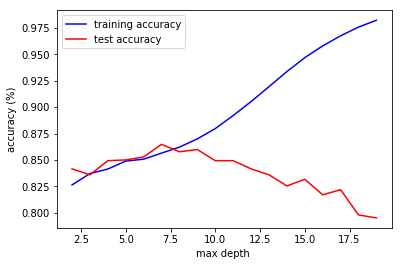

In [15]:
plt.plot(tree_depth,tree_train_acc,'b', label="training accuracy")
plt.plot(tree_depth,tree_test_acc,'r', label="test accuracy")
plt.ylabel('accuracy (%)')
plt.xlabel('max depth ')
plt.legend()
plt.show()

In [16]:

best_depth = tree_depth[tree_test_acc.index(max(tree_test_acc))]
print ("max depth: ", best_depth)
print ("best test accuracy: %.5f"% max(tree_test_acc))

max depth:  7
best test accuracy: 0.86479


從上圖可以看出，訓練數據的正確率隨著max_depth的增加而上升，但是測試數據的正確率不會。max_depth=7時，測試數據的正確率達到最高，約略為0.86479%。所以可以認定max_depth=7時的模型較好，max_depth>7的模型會有overfitting的現象。

In [17]:
#dtree=tree.DecisionTreeClassifier(max_depth=7)
#dtree=dtree.fit(train_x,train_y)
#predict_y = dtree.predict(test_x)
#X=accuracy_score(test_y, predict_y)
#print('max_depth=7 test accuracy: %.5f' % X)

In [18]:
#模型評價 auc
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y, pos_label=1)
print('max_depth=7 auc: %.5f' % metrics.auc(fpr, tpr))

max_depth=7 auc: 0.72791


auc>0.5 表示模型預測比隨機猜測準確

In [19]:
# 交叉驗證 cross validation 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
scores = cross_val_score(dtree,train_x,train_y,cv=5,scoring='accuracy')

# 計算平均值與標準差
print('average of Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

average of Cross validation: 0.79047
standard deviation of Cross validation: 0.01281


#### 4.2 Decision tree結果觀察
1. 3層的決策樹可以有83.6%的正確率。
2. 7層的決策樹的預測正確率最高，有86.5%。

## 5.不同的模型
### 5.1 logistic regression

In [20]:
# logistic regression

logreg = LogisticRegression()
logreg = logreg.fit(train_x, train_y)
predict_y = logreg.predict(test_x)
acc_log = logreg.score(train_x, train_y)
print('training accuracy: %.5f' % acc_log)

predict_y =logreg.predict(test_x)
X=accuracy_score(test_y, predict_y)
print('test accuracy: %.5f' % X)

#auc
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y, pos_label=1)
print('auc: %.5f' % metrics.auc(fpr, tpr))

#Cross validation
scores = cross_val_score(logreg,train_x,train_y,cv=5,scoring='accuracy')
# 計算Cross validation的平均值與標準差
print('average of Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


training accuracy: 0.85240
test accuracy: 0.86972
auc: 0.79875


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

average of Cross validation: 0.85069
standard deviation of Cross validation: 0.00731


In [21]:
# Support Vector Machines
#運算時間太長
'''
svc = SVC(gamma='auto',C=0.1,kernel="linear", probability=True)
svc.fit(train_x, train_y)
predict_y= svc.predict(test_x)
acc_svc = svc.score(train_x, train_y)
print('training accuracy: %.5f' % acc_svc)

predict_y =svc.predict(test_x)
X=accuracy_score(test_y, predict_y)
print('test accuracy: %.5f' % X)'''

'\nsvc = SVC(gamma=\'auto\',C=0.1,kernel="linear", probability=True)\nsvc.fit(train_x, train_y)\npredict_y= svc.predict(test_x)\nacc_svc = svc.score(train_x, train_y)\nprint(\'training accuracy: %.5f\' % acc_svc)\n\npredict_y =svc.predict(test_x)\nX=accuracy_score(test_y, predict_y)\nprint(\'test accuracy: %.5f\' % X)'


### 5.2 knn

In [22]:
# knn

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(train_x, train_y)
predict_y = knn.predict(test_x)
acc_knn = knn.score(train_x, train_y)
print('training accuracy: %.5f' % acc_knn)

predict_y =knn.predict(test_x)
X=accuracy_score(test_y, predict_y)
print('test accuracy: %.5f' % X)

#auc
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y, pos_label=1)
print('auc: %.5f' % metrics.auc(fpr, tpr))

#Cross validation
scores = cross_val_score(knn,train_x,train_y,cv=5,scoring='accuracy')
print('average of Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

training accuracy: 0.86764
test accuracy: 0.86338
auc: 0.77603
average of Cross validation: 0.83918
standard deviation of Cross validation: 0.00643


### 5.3 Gaussian Naive Bayes

In [23]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(train_x, train_y)
predict_y = gaussian.predict(test_x)
acc_gaussian = gaussian.score(train_x, train_y)
print('training accuracy: %.5f' % acc_gaussian)

predict_y =gaussian.predict(test_x)
X=accuracy_score(test_y, predict_y)
print('test accuracy: %.5f' % X)

#auc
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y, pos_label=1)
print('auc: %.5f' % metrics.auc(fpr, tpr))

#Cross validation
scores = cross_val_score(gaussian,train_x,train_y,cv=5,scoring='accuracy')
print('average of Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

training accuracy: 0.80180
test accuracy: 0.84789
auc: 0.78723
average of Cross validation: 0.79778
standard deviation of Cross validation: 0.03710


## 6.後續工作
1. 使用Random forest 
2. 將風向的資料、且將日期轉換成季節，重新加入訓練模型中，確認是否有更好的結果。
3. 可以將Location重新加入訓練模型，預測各地點明天是否降雨。

(註：「後續工作」是口頭報告時還未完成的工作)


### 6.1 Random Forest

#### 6.1.1 計算n_estimators=1000的情況

In [24]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(bootstrap=True, n_estimators=1000, max_depth=7)
rdf.fit(train_x, train_y)  

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [25]:
acc_log = rdf.score(train_x, train_y)
print('training accuracy: %.5f' % acc_log)

predict_y =rdf.predict(test_x)
X=accuracy_score(test_y, predict_y)
print('test accuracy: %.5f' % X)
#auc
fpr, tpr, thresholds = metrics.roc_curve(test_y, predict_y, pos_label=1)
print('auc: %.5f' % metrics.auc(fpr, tpr))

#Cross validation
#運算時間太長
'''scores = cross_val_score(rdf,train_x,train_y,cv=5,scoring='accuracy')
print(scores)
print('Cross validation: %.5f'%scores.mean())'''

training accuracy: 0.85900
test accuracy: 0.85141
auc: 0.72911


"scores = cross_val_score(rdf,train_x,train_y,cv=5,scoring='accuracy')\nprint(scores)\nprint('Cross validation: %.5f'%scores.mean())"

#### 6.1.2 決定最佳的n_estimators

In [26]:
#Parameters:決定最佳的n_estimators
#目前只算到n_estimators=256，太大需要時間過長

from sklearn import model_selection, metrics

def scorer(model, X,  train_y):
    preds = model.predict(X)
    return metrics.accuracy_score( train_y, preds)

n_estimators = [1,2,4,8,16,32,64,128, 256]  ## try different n_estimators
cv_results = []

for estimator in n_estimators:
    rf = RandomForestClassifier(n_estimators=estimator)
    acc = model_selection.cross_val_score(rf, train_x,  train_y, cv=5, scoring=scorer)
    cv_results.append(acc.mean())

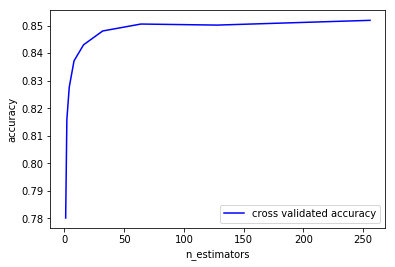

In [27]:
line1= plt.plot(n_estimators, cv_results, 'b', label="cross validated accuracy")
plt.ylabel('accuracy')
plt.xlabel('n_estimators')
plt.legend()
plt.show()

從目前的結果可知，在n_estimators=256以內，正確率有上升的趨勢，而且n_estimators越大，上升趨勢越緩。但是因為計算時間的問題，n_estimators>256的情況暫時不計算。

In [28]:
best_n_estimators = n_estimators[cv_results.index(max(cv_results))]
print ("best_n_estimators: ", best_n_estimators)
print ("best accuracy: ", max(cv_results))

best_n_estimators:  256
best accuracy:  0.8519636363636363


#### 6.1.3 random forest結果觀察
和使用Decision tree相比，random forest沒有提高正確率。

### 6.2 將地點考慮進去


In [29]:
pd_data = pd.read_csv('../input/weatherAUS.csv')
pd_data=pd_data.dropna(how='any')
print(pd_data.shape)


(56420, 24)


In [30]:
drop_columns_list = ['WindGustDir', 'WindDir9am', 'WindDir3pm','Date','Sunshine','RISK_MM']
pd_data = pd_data.drop(drop_columns_list, axis=1)
print(pd_data.shape)

pd_data['RainToday'].replace({'No':0,'Yes':1},inplace=True)
pd_data['RainTomorrow'].replace({'No':0,'Yes':1},inplace=True)

(56420, 18)


In [31]:
groupbyLocation=pd_data.groupby('Location')
print(groupbyLocation.size().sort_values(ascending=False))


Location
Darwin              3062
Perth               3025
Brisbane            2953
MelbourneAirport    2929
PerthAirport        2913
SydneyAirport       2870
Watsonia            2730
Mildura             2594
MountGambier        2465
NorfolkIsland       2464
Cairns              2444
Townsville          2419
WaggaWagga          2416
AliceSprings        2223
Nuriootpa           2008
Hobart              1939
Moree               1913
Melbourne           1898
Portland            1863
Woomera             1734
Sydney              1690
Sale                1678
CoffsHarbour        1380
Williamtown         1198
Canberra            1078
Cobar                534
dtype: int64


#### 6.2.1 把地點轉為數字

In [32]:
pd_data['Location'] = pd_data['Location'].map( {'Darwin':0,'Perth':1,'Brisbane':2,'MelbourneAirport':3,
                                                'PerthAirport':4,'SydneyAirport':5,'Watsonia':6,'Mildura':7,
                                                'MountGambier':8,'NorfolkIsland':9,'Cairns':10,'Townsville':11,
                                                'WaggaWagga':12,'AliceSprings':13,'Nuriootpa':14,'Hobart':15,
                                                'Moree':16,'Melbourne':17,'Portland':18,'Woomera':19,
                                                'Sydney':20,'Sale':21,'CoffsHarbour':22,'Williamtown':23,
                                                'Canberra':24,'Cobar':25} ).astype(int)
train_y=pd_data['RainTomorrow']
train_x=pd_data.drop(['RainTomorrow'], axis=1)

In [33]:
dtree=tree.DecisionTreeClassifier(max_depth=7)
dtree=dtree.fit(train_x,train_y)
scores = cross_val_score(dtree,train_x,train_y,cv=5,scoring='accuracy')
print(scores)
print('average of Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

[0.81577315 0.82605228 0.83224034 0.84853319 0.85473722]
average of Cross validation: 0.83547
standard deviation of Cross validation: 0.01604


#### 6.2.2 Logistic Regression

In [34]:
#Logistic Regression
logreg = LogisticRegression()
logreg.fit(train_x, train_y)

#Cross validation
scores = cross_val_score(dtree,train_x,train_y,cv=5,scoring='accuracy')
print('Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross validation: 0.83548
standard deviation of Cross validation: 0.01604


#### 6.2.3 knn

In [35]:
#knn
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(train_x, train_y)

#Cross validation
scores = cross_val_score(knn,train_x,train_y,cv=5,scoring='accuracy')
print('Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

Cross validation: 0.83306
standard deviation of Cross validation: 0.00987


#### 6.2.4 Gaussian Naive Bayes

In [36]:
#Gaussian Naive Bayes
gaussian = GaussianNB()
gaussian.fit(train_x, train_y)
#Cross validation
scores = cross_val_score(gaussian,train_x,train_y,cv=5,scoring='accuracy')
print('Cross validation: %.5f'%scores.mean())
print('standard deviation of Cross validation: %.5f'%scores.std(ddof=1))

Cross validation: 0.80876
standard deviation of Cross validation: 0.02834


#### 6.2.5 將地點考慮進去的結果觀察
正確率並沒有提升。

## 7.小結

1.我們嘗試使用各種模型預測，預測準確度都能達到80%以上。

2.各個模型的auc都大於0.7，有些模型可達0.8以上，表示使用這些模型預測「明天是否降雨的正確率」都比亂猜的結果來得好。

## 8.心得
#### 廖品瑜:
#### 感覺課程時間有點少，希望可以用更多時間在帶程式的部分，雖然原理很重要，但講解過大概後應該可以透過自學來完成；而程式的部分就算不太懂原理也可以上手，但需要更多次練習才能找出問題。這次學到的東西很有趣，電腦可以直接引用函式庫真的太方便了，幾乎不需要了解原理就可以使用。也學到Git跟Kaggle還有Jupyter notebook的用法，以後會更深入學習，希望可以在原本的科系上運用。
#### 胡筆勝:
#### 課程內容很有趣也很實用，之前完全沒有接觸過相關的領域，但是在一個禮拜內要了解機器學習以及python的課程內容，我覺得有些許困難。繳交作業時間延後之後，我可以有更多時間時作與思考課程內容。